# Linear Regression using stock market data and stock indicators

This is a simple example using Linear Regression to predict stock prices. Stock data is loaded from the web using pandas datareader, a few features are added, and predictions are made using Linear Regression.

Secondly, multiple features are added (although not throughly thought out) by calculating technical indicators using TA-Lib. Normally this is not recommended as it leads to underfitting or overfitting (and possibly just creating a lot of noise).

When time permits, I will dive deeper into the technical indicators, apply them properly, and use backward elimination to find those that add value to the model.

In [31]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import warnings
import datetime
from datetime import datetime as dt, timedelta
import time
warnings.filterwarnings('ignore')

# machine learning...
from sklearn import preprocessing, svm, cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# visualization...
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

# to calculate technical indicators
import talib
from talib.abstract import *

matplotlib.style.use('ggplot')
import sys

## Load open, high, low, close data for Apple

Load data for Apple using pandas datareader (Investors Exchange data)
 - more info: http://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-iex

In [2]:
ticker = "AAPL"
start = dt.today() - timedelta(days=5*365)
end = dt.now()

df = web.DataReader(ticker, 'iex', start, end) 

# convert index to datetime...
df.index = pd.to_datetime(df.index)

df.info()
df.tail()
df.index

5y
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2013-06-12 to 2018-06-08
Data columns (total 5 columns):
open      1258 non-null float64
high      1258 non-null float64
low       1258 non-null float64
close     1258 non-null float64
volume    1258 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


DatetimeIndex(['2013-06-12', '2013-06-13', '2013-06-14', '2013-06-17',
               '2013-06-18', '2013-06-19', '2013-06-20', '2013-06-21',
               '2013-06-24', '2013-06-25',
               ...
               '2018-05-25', '2018-05-29', '2018-05-30', '2018-05-31',
               '2018-06-01', '2018-06-04', '2018-06-05', '2018-06-06',
               '2018-06-07', '2018-06-08'],
              dtype='datetime64[ns]', name='date', length=1258, freq=None)

## Display as candlestick

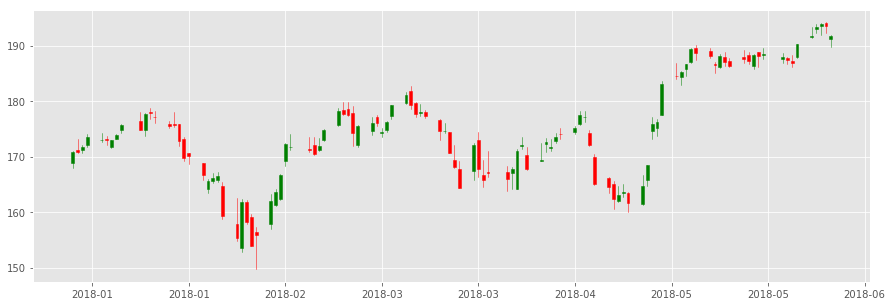

In [3]:
# pull date out of index and convert
df['date']= matplotlib.dates.date2num(df.index.to_pydatetime())

# plot from beginning of year...
start = matplotlib.dates.datestr2num('2018-01-01')

# dataframe to plot
ohlc =  df[['date','open','high','low','close']][df.date > start]
f1, ax = plt.subplots(figsize = (15,5))

# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

# drop date column used for plot
df = df.drop('date', axis=1)

In [4]:
print(df['20180501':pd.to_datetime('today')].close)

date
2018-05-01    168.4505
2018-05-02    175.8918
2018-05-03    176.2106
2018-05-04    183.1239
2018-05-07    184.4488
2018-05-08    185.3354
2018-05-09    186.6404
2018-05-10    189.3101
2018-05-11    188.5900
2018-05-14    188.1500
2018-05-15    186.4400
2018-05-16    188.1800
2018-05-17    186.9900
2018-05-18    186.3100
2018-05-21    187.6300
2018-05-22    187.1600
2018-05-23    188.3600
2018-05-24    188.1500
2018-05-25    188.5800
2018-05-29    187.9000
2018-05-30    187.5000
2018-05-31    186.8700
2018-06-01    190.2400
2018-06-04    191.8300
2018-06-05    193.3100
2018-06-06    193.9800
2018-06-07    193.4600
2018-06-08    191.7000
Name: close, dtype: float64


## Add a few Features to the data (later we'll add plenty more!)

In [5]:
# high low %...
df['highlow_pct'] = (df['high'] - df['low']) / (df['low']*100)

# percent change...
df['pct_change'] = (df['close'] - df['open']) / (df['open']*100)

## Prepare the data for classification
- set the target column (dependant variable)
- how many days forward to predict

In [6]:
# the column to predict 
target_col = 'close'

# predict the last 30 days...
prediction_days = 30

print('observations =',len(df), "\ndays to predict =", prediction_days)

observations = 1258 
days to predict = 30


Next, add a new column target_close that contains the close price n days into the future (n=prediction_days)


In [7]:
# add a target_close column - the close value n days in the future
df['target_close'] = df[target_col].shift(-prediction_days)


print("For example, these target_close values:")
print(df[['close','target_close']].head(5))
print("\n")
print("...were pulled from the close of these rows")
print(df[['close']].iloc[15:20])

For example, these target_close values:
              close  target_close
date                             
2013-06-12  56.3584       57.1813
2013-06-13  56.8507       57.5060
2013-06-14  56.0794       58.3927
2013-06-17  56.3336       59.1138
2013-06-18  56.3037       59.0108


...were pulled from the close of these rows
              close
date               
2013-07-03  54.8731
2013-07-05  54.4324
2013-07-08  54.1233
2013-07-09  55.0753
2013-07-10  54.8640


Preserve the dates and predictor variable (date and close) 
<br>(this dataframe will be used later to add predictions and actual close back in to plot the differences)

In [8]:
X_date_pred = pd.DataFrame(df.close, df.index)

#### Feature Matrix
create a feature matrix with all the columns except target_close and scale the data

In [9]:
# set feature matrix to all columns except target_close
X = np.array(df.drop(['target_close'], axis=1))
print(X[1:])

# scale features using sklearn preprocessing scale
X = preprocessing.scale(X)
print(X[1:])

[[  5.63988000e+01   5.70039000e+01   5.59098000e+01 ...,   7.14566930e+07
    1.95690201e-04   8.01258183e-05]
 [  5.67770000e+01   5.68931000e+01   5.58772000e+01 ...,   6.79624190e+07
    1.81809396e-04  -1.22866654e-04]
 [  5.62606000e+01   5.68161000e+01   5.61200000e+01 ...,   6.48186700e+07
    1.24037776e-04   1.29753326e-05]
 ..., 
 [  1.93630000e+02   1.94080000e+02   1.91920000e+02 ...,   2.09336190e+07
    1.12546895e-04   1.80757114e-05]
 [  1.94140000e+02   1.94200000e+02   1.92335000e+02 ...,   2.13471800e+07
    9.69662308e-05  -3.50262697e-05]
 [  1.91170000e+02   1.92000000e+02   1.89770000e+02 ...,   2.66567990e+07
    1.17510671e-04   2.77240153e-05]]
[[-1.66114931 -1.65987404 -1.65876664 ...,  0.8019242   0.25430566
   0.66224897]
 [-1.64991899 -1.66314273 -1.65974089 ...,  0.67920604  0.11788335
  -1.07477719]
 [-1.66525304 -1.6654143  -1.6524848  ...,  0.56879824 -0.44990349
   0.08763579]
 ..., 
 [ 2.4138101   2.38398239  2.40590894 ..., -0.97243543 -0.56283734


Remove the last n days out of the dataframe (predictions will be generated for these last n days) and create X,y

In [10]:
X_target_features = X[-prediction_days:]
X_date_pred = X_date_pred[-prediction_days:]

# reset the matirx of features to contain all the data except for the last 30 days
X = X[:-prediction_days]

# net set y to the traget column
y = np.array(df['target_close'])
# remove the last 30 days as we did with the features matrix
y = y[:-prediction_days]


print('Lenght of target:', len(X_target_features))
print('Lenght of X:', len(X))
print('Lenght of y:', len(y))

Lenght of target: 30
Lenght of X: 1228
Lenght of y: 1228


### Create Test and Train sets
Use Cross validation to split into test and train data)

In [11]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  982 246


## Classify with Linear Regression

In [12]:
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.925591810172


### Get the predictions

In [13]:
predictions = clf.predict(X_target_features)
print(predictions)

[ 165.70077074  168.44280079  170.35457882  178.03269312  178.17536559
  185.44474991  186.76730351  186.54819843  187.63794904  190.1903521
  190.79888595  189.66024207  187.80792567  189.1032781   189.53874522
  187.97966893  189.69308476  189.37675459  189.47749578  190.11747654
  189.93198865  189.03158028  188.23180282  188.47583553  190.9256562
  193.16895908  193.96821299  194.91611565  194.69017121  192.6696556 ]


Create a dataframe with the predictions

In [14]:
df_predictions = pd.DataFrame(X_date_pred)
df_predictions['prediction'] = predictions
df_predictions.rename(columns={'close': 'actual'}, inplace=True)

# Plot the predictions with the actual close

In [15]:
df.tail()

,open,high,low,close,volume,highlow_pct,pct_change,target_close
date,,,,,,,,
2018-06-04,191.635,193.42,191.350,191.83,26266174,0.000108,0.000010,NaN
2018-06-05,193.065,193.94,192.360,193.31,21565963,0.000082,0.000013,NaN
2018-06-06,193.630,194.08,191.920,193.98,20933619,0.000113,0.000018,NaN
2018-06-07,194.140,194.20,192.335,193.46,21347180,0.000097,-0.000035,NaN
2018-06-08,191.170,192.00,189.770,191.70,26656799,0.000118,0.000028,NaN


In [16]:
# dropping na in this case will drop the last x rows (these are the predicted values)
df_plot = df
df_plot.dropna(inplace=True)

In [17]:
# add the predictions back to the df and reindex
df_plot = df_plot.append(df_predictions)

In [18]:
df_plot.reset_index()

,date,actual,close,high,highlow_pct,low,open,pct_change,prediction,target_close,volume
0,2013-06-12,NaN,56.3584,57.5399,0.000226,56.2684,57.3117,-0.000166,NaN,57.1813,66295887.0
1,2013-06-13,NaN,56.8507,57.0039,0.000196,55.9098,56.3988,0.000080,NaN,57.5060,71456693.0
2,2013-06-14,NaN,56.0794,56.8931,0.000182,55.8772,56.7770,-0.000123,NaN,58.3927,67962419.0
3,2013-06-17,NaN,56.3336,56.8161,0.000124,56.1200,56.2606,0.000013,NaN,59.1138,64818670.0
4,2013-06-18,NaN,56.3037,56.7118,0.000109,56.1002,56.2763,0.000005,NaN,59.0108,48753768.0
5,2013-06-19,NaN,55.1600,56.2893,0.000205,55.1600,56.2554,-0.000195,NaN,59.5514,77715057.0
6,2013-06-20,NaN,54.3565,55.5486,0.000260,54.1390,54.6775,-0.000059,NaN,60.3161,89327210.0
7,2013-06-21,NaN,53.9212,54.7688,0.000292,53.2171,54.5719,-0.000119,NaN,61.2172,120286768.0
8,2013-06-24,NaN,52.4920,53.2901,0.000267,51.9065,53.1258,-0.000119,NaN,61.0701,120104964.0
9,2013-06-25,NaN,52.5037,53.1766,0.000225,52.0082,52.9041,-0.000076,NaN,61.0346,78534687.0


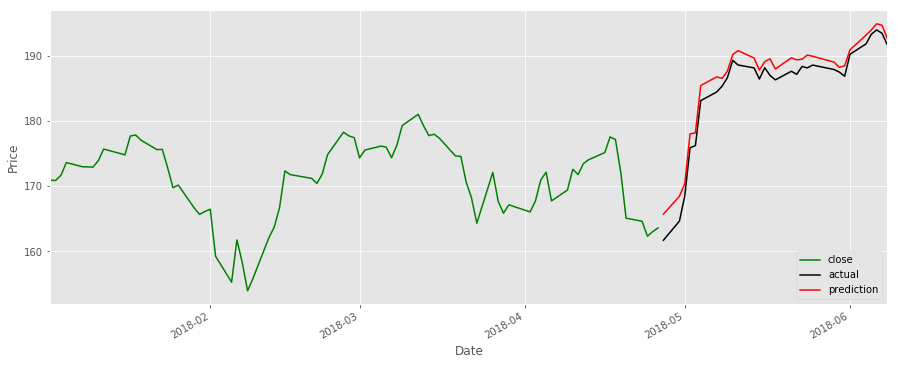

In [19]:
# plot since the beginning of year overlaying actual and prediction in red
df_plot['20180101':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green")
df_plot['20180101':pd.to_datetime('today')]['actual'].plot(figsize=(15,6), color="black")
df_plot['20180101':pd.to_datetime('today')]['prediction'].plot(figsize=(15,6), color="red")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [20]:
# view predictions next to actual
df_predictions['20180501':pd.to_datetime('today')]

,actual,prediction
date,,
2018-05-01,168.4505,170.354579
2018-05-02,175.8918,178.032693
2018-05-03,176.2106,178.175366
2018-05-04,183.1239,185.444750
2018-05-07,184.4488,186.767304
2018-05-08,185.3354,186.548198
2018-05-09,186.6404,187.637949
2018-05-10,189.3101,190.190352
2018-05-11,188.5900,190.798886


# Further Feature Engineering
### Technical Analysis Indicators
Now, brute force a bunch of stock indicators as features and re-classify.  Normally you would apply domain knowledge to properly setup each indicator and then go through the process of features elimination, but in order to save time lets just plow in a bunch of indicators to see if the prediction improves

Indicators were generated using TA-Lib (https://mrjbq7.github.io/ta-lib/).  For each indicator in the Overlap Studies, Momentum Indicators, Cycle Indicators, and Statistic Functions (most of which require only the close column from our dataset) generate features for 5 and 10 days.  

For Example calling gen_from_indicator("MA", 5) 
    - generate a column MA_5 with the indictor value.

### Function to generate features

In [21]:
def gen_from_indicator(df, indicator, param = 0):
    """
    generates a new feature by running the passed in indicator for the parameter specified.
    """
    try:        
        afunc = talib.abstract.Function(indicator) 
        
        if (param != 0):
            key = indicator + "_" + str(param)
            df[key] = afunc(df, param)
                    
        else:
            key = indicator
            df[key] = afunc(df)
                    
    except:
        pass
        #print('inncorrect parameters for indicator: ', indicator)
        # proper catch *all* exceptions
        #e = sys.exc_info()[0]
        #print("error for: ",indicator, e)    

Get a list of all the funtions in TA-Lib

In [22]:
all_funcs = talib.get_function_groups()
print(all_funcs['Overlap Studies'])
print(all_funcs['Momentum Indicators'])
print(all_funcs['Cycle Indicators'])
print(all_funcs['Statistic Functions'])

['BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA']
['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR']
['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE']
['BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


Loop through the different groups and generate features (note: this will error quit a bit as not all TA functions take just the close value)

In [23]:
print("create features for overlap studies")
for key in all_funcs['Overlap Studies']:
    #print(key) 
    gen_from_indicator(df, key, 5)     # process 5 days back
    gen_from_indicator(df, key, 10)    # process 10 days back

print("create features for overlap indicators")
for key in all_funcs['Momentum Indicators']:
    #print(key)
    gen_from_indicator(df, key, 5)
    gen_from_indicator(df, key, 10)
   
print("create features for overlap indicators")
for key in all_funcs['Cycle Indicators']:
    #print(key)
    gen_from_indicator(df, key, 5)    
    gen_from_indicator(df, key, 10)
    
print("create features for Statistic Functions")
for key in all_funcs['Statistic Functions']:
    #print(key)    
    gen_from_indicator(df, key, 5)    
    gen_from_indicator(df, key, 10)

create features for overlap studies
create features for overlap indicators
create features for overlap indicators
create features for Statistic Functions


# Re-classify and predict with added features

In [24]:
# all the new columns!
cols = df.columns.tolist()
print(cols)

['open', 'high', 'low', 'close', 'volume', 'highlow_pct', 'pct_change', 'target_close', 'DEMA_5', 'DEMA_10', 'EMA_5', 'EMA_10', 'HT_TRENDLINE_5', 'HT_TRENDLINE_10', 'KAMA_5', 'KAMA_10', 'MA_5', 'MA_10', 'MIDPOINT_5', 'MIDPOINT_10', 'MIDPRICE_5', 'MIDPRICE_10', 'SAR_5', 'SAR_10', 'SAREXT_5', 'SAREXT_10', 'SMA_5', 'SMA_10', 'T3_5', 'T3_10', 'TEMA_5', 'TEMA_10', 'TRIMA_5', 'TRIMA_10', 'WMA_5', 'WMA_10', 'ADX_5', 'ADX_10', 'ADXR_5', 'ADXR_10', 'APO_5', 'APO_10', 'AROONOSC_5', 'AROONOSC_10', 'BOP_5', 'BOP_10', 'CCI_5', 'CCI_10', 'CMO_5', 'CMO_10', 'DX_5', 'DX_10', 'MINUS_DI_5', 'MINUS_DI_10', 'MINUS_DM_5', 'MINUS_DM_10', 'MOM_5', 'MOM_10', 'PLUS_DI_5', 'PLUS_DI_10', 'PLUS_DM_5', 'PLUS_DM_10', 'PPO_5', 'PPO_10', 'ROC_5', 'ROC_10', 'ROCP_5', 'ROCP_10', 'ROCR_5', 'ROCR_10', 'ROCR100_5', 'ROCR100_10', 'RSI_5', 'RSI_10', 'TRIX_5', 'TRIX_10', 'ULTOSC_5', 'ULTOSC_10', 'WILLR_5', 'WILLR_10', 'HT_DCPERIOD_5', 'HT_DCPERIOD_10', 'HT_DCPHASE_5', 'HT_DCPHASE_10', 'HT_TRENDMODE_5', 'HT_TRENDMODE_10', 'BE

In [25]:
# note: the indicators will have a bunch of NAN's because they need x number of days of data before the calculated data begins
# threfore, drop those rows before classifing
df.dropna(inplace=True)


# add a target_close column - the close value n days in the future
df['target_close'] = df[target_col].shift(-prediction_days)

# preserve the dates and predictor variable (date and close) 
X_date_pred = pd.DataFrame(df.close, df.index)

# set feature matrix to all columns except target_close
X = np.array(df.drop(['target_close'], axis=1))

# scale features using sklearn preprocessing scale
X = preprocessing.scale(X)

# pull the last 30 days out of the dataframe, this will be used to generate predictions
X_target_features = X[-prediction_days:]
X_date_pred = X_date_pred[-prediction_days:]

# reset the matirx of features to contain all the data except for the last 30 days
X = X[:-prediction_days]

# net set y to the traget column
y = np.array(df['target_close'])

# remove the last 30 days as we did with the features matrix
y = y[:-prediction_days]

# Cross validation (split into test and train data)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

# Train
clf = LinearRegression()
clf.fit(X_train,y_train)

# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

# Predict using our Model
predictions = clf.predict(X_target_features)
print(predictions)

# setup dataframe with predictions
df_predictions = pd.DataFrame(X_date_pred)
df_predictions['prediction'] = predictions
df_predictions.rename(columns={'close': 'actual'}, inplace=True)

Accuracy of Linear Regression:  0.945426808577
[ 174.73464507  173.35964507  171.35964507  172.10964507  173.60964507
  175.10964507  171.10964507  176.35964507  171.10964507  174.10964507
  174.60964507  173.35964507  174.60964507  181.98464507  182.48464507
  179.35964507  176.60964507  177.73464507  179.35964507  179.23464507
  180.60964507  182.60964507  177.60964507  174.48464507  176.85964507
  177.60964507  182.35964507  190.48464507  187.60964507  189.10964507]


# Plot with added features 

In [26]:
# dropping na in this case will drop the last x rows (these are the predicted values)
df.dropna(inplace=True)

In [27]:
# add the predictions back to the df and reindex
df = df.append(df_predictions)

In [28]:
df.reset_index()

,date,ADXR_10,ADXR_5,ADX_10,ADX_5,APO_10,APO_5,AROONOSC_10,AROONOSC_5,BETA_10,...,actual,close,high,highlow_pct,low,open,pct_change,prediction,target_close,volume
0,2013-09-11,37.172416,25.690829,29.062896,30.414552,0.315432,0.380112,-20.0,-40.0,0.780629,...,NaN,61.3930,62.1779,0.000191,61.0123,61.3011,0.000015,NaN,68.9078,224250866.0
1,2013-09-12,36.063686,27.907126,29.464214,35.545739,0.038901,-0.250229,-20.0,-40.0,0.798696,...,NaN,62.0467,62.4024,0.000202,61.1698,61.4967,0.000089,NaN,69.8201,100874816.0
2,2013-09-13,34.564888,30.476016,29.960029,39.973985,-0.312485,-1.124565,-40.0,-80.0,0.783378,...,NaN,61.0241,61.9337,0.000153,60.9979,61.6070,-0.000095,NaN,69.0388,74578903.0
3,2013-09-16,34.657115,34.557130,31.913177,46.735796,-0.744438,-2.541028,-50.0,-100.0,0.840332,...,NaN,59.0841,60.5923,0.000322,58.7034,60.5122,-0.000236,NaN,69.5531,136823442.0
4,2013-09-17,34.874756,41.279898,33.671010,52.145245,-1.185411,-3.577681,-50.0,-80.0,0.889987,...,NaN,59.7666,60.3429,0.000273,58.7402,58.8005,0.000164,NaN,67.8207,99756489.0
5,2013-09-18,33.984641,42.808254,33.798787,50.070770,-1.618320,-3.643710,-50.0,-40.0,0.931394,...,NaN,60.9952,61.2145,0.000124,60.4676,60.7984,0.000032,NaN,68.8994,113743049.0
6,2013-09-19,31.799819,40.685351,32.109767,41.396717,-1.832642,-3.566762,-50.0,60.0,0.932829,...,NaN,61.9955,62.4588,0.000140,61.5951,61.7855,0.000034,NaN,68.6114,100918377.0
7,2013-09-20,30.844280,41.490960,30.992282,36.246124,-2.080100,-3.343900,-50.0,80.0,0.913853,...,NaN,61.3536,62.8159,0.000269,61.1685,62.7437,-0.000222,NaN,68.2607,174570949.0
8,2013-09-23,28.435718,43.674773,28.620069,35.204301,-2.247246,-2.243456,-50.0,100.0,0.888151,...,NaN,64.4028,65.2259,0.000297,63.3475,65.1195,-0.000110,NaN,69.1427,190021706.0
9,2013-09-24,27.773987,42.220806,26.485078,34.370843,-2.253174,-1.289844,-40.0,80.0,0.890058,...,NaN,64.2007,65.0368,0.000157,64.0327,64.9594,-0.000117,NaN,68.9720,90602953.0


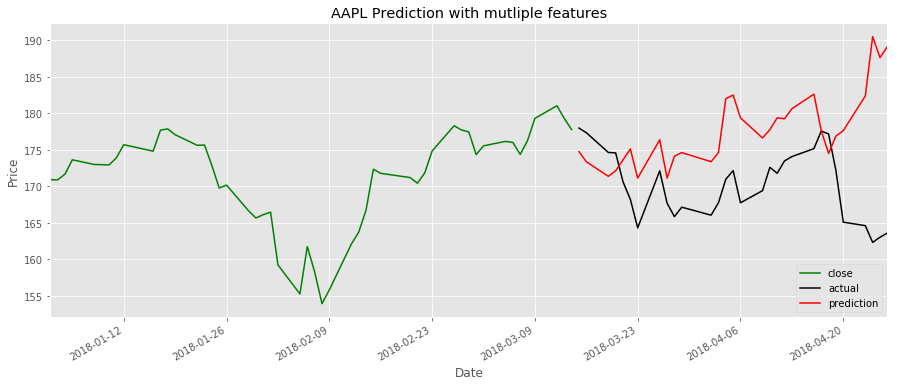

In [29]:
# plot since the beginning of year overlaying actual and prediction in red
df['20180101':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green")
df['20180101':pd.to_datetime('today')]['actual'].plot(figsize=(15,6), color="black")
df['20180101':pd.to_datetime('today')]['prediction'].plot(figsize=(15,6), color="red")
plt.title('AAPL Prediction with mutliple features')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

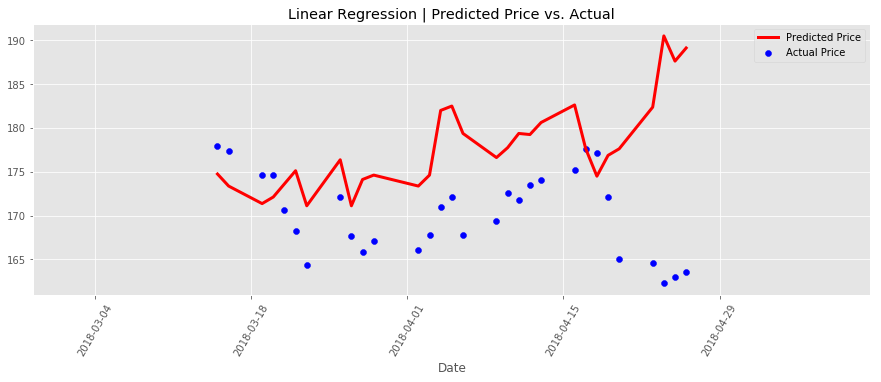

In [30]:
# plot predictions
plt.figure(figsize=(15,5))
plt.scatter(df_predictions.index, df_predictions.actual, color='blue', label= 'Actual Price') # plot the actual datapoints
plt.plot(df_predictions.index, df_predictions.prediction, color='red', linewidth=3, label='Predicted Price') # plot the line made by linear regression
plt.title('Linear Regression | Predicted Price vs. Actual')
plt.legend(loc=4)
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('Date')
plt.show()

# Conclusion
It is amazing to see how machine learning can produce descent results with such little data.  Also, its no surprise that adding random features just created a lot noise and didn't add any value.   